# Lensing Background Galaxies by Foreground Halos

#### Spencer Everett, SLAC 7/29/2015

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import os,sys
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import cmath
import cPickle as pickle
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
%matplotlib inline

In [3]:
# Pangloss:
PANGLOSS_DIR = os.path.expandvars("$PANGLOSS_DIR")
sys.path.append(PANGLOSS_DIR)
import pangloss

Import the convergence and shear maps:

In [4]:
K = pangloss.Kappamap(PANGLOSS_DIR+'/data/GGL_los_8_0_0_N_4096_ang_4_rays_to_plane_37_f.kappa',FITS=False)

In [5]:
S = pangloss.Shearmap([PANGLOSS_DIR+'/data/GGL_los_8_0_0_N_4096_ang_4_rays_to_plane_37_f.gamma_1',PANGLOSS_DIR+'/data/GGL_los_8_0_0_N_4096_ang_4_rays_to_plane_37_f.gamma_2'],FITS=False)

Import the foreground galaxy catalog for the (0,0,0,0) field:

In [6]:
config = pangloss.Configuration(PANGLOSS_DIR+'/example/example.config')
F = pangloss.ForegroundCatalog(PANGLOSS_DIR+'/data/GGL_los_8_0_0_0_0_N_4096_ang_4_Guo_galaxies_on_plane_27_to_63.images.txt',config)

Generate a background galaxy catalog in a small part of the same field with 10 sources per square arcminute:

In [7]:
B = pangloss.BackgroundCatalog(N=40,sigma_e=0.01,domain=[1.55,1.52,-1.61,-1.59],field=[0,0,0,0])
B.lens_by_map(K,S)
B.galaxy_count


86

In [8]:
B.drill_lightcones(foreground=F,save=False)

In [9]:
galaxy_counts = [B.lightcones[i].galaxy_count for i in range(len(B.lightcones))]
mean_galaxies = np.mean(galaxy_counts)
std_galaxies = np.std(galaxy_counts)
print mean_galaxies,'+/-',std_galaxies

1042.1744186 +/- 22.6305986831


In [10]:
B.lens_by_halos()

0
10
20
30
40
50
60
70
80
average CPU time per background galaxy:  0.0524295596189 +/- 0.0813386798028


In [11]:
k_diff = abs((B.galaxies['kappa_halo']-B.galaxies['kappa'])/B.galaxies['kappa'])*100.0
k_diff_mean = np.mean(k_diff)
k_diff_std = np.std(k_diff)
print 'k_diff mean: ',k_diff_mean,'%'
print 'k_diff std: ',k_diff_std,'%'
print

g_diff = abs((B.galaxies['g_halo']-B.galaxies['g'])/B.galaxies['g'])*100.0
g_diff_mean = np.mean(g_diff)
g_diff_std = np.std(g_diff)
print 'g_diff mean: ',g_diff_mean,'%'
print 'g_diff std: ',g_diff_std,'%'
print

mod_diff = abs((B.galaxies['eMod_halo']-B.galaxies['eMod'])/B.galaxies['eMod'])*100.0
mod_diff_mean = np.mean(mod_diff)
mod_diff_std = np.std(mod_diff)
print 'mod_diff mean: ',mod_diff_mean,'%'
print 'mod_diff std: ',mod_diff_std,'%'
print

phi_diff = abs((B.galaxies['ePhi_halo']-B.galaxies['ePhi'])/B.galaxies['ePhi'])*100.0
phi_diff_mean = np.mean(phi_diff)
phi_diff_std = np.std(phi_diff)
print 'phi_diff mean: ',phi_diff_mean,'%'
print 'phi_diff std: ',phi_diff_std,'%'
print

print 'mean kappa: ',np.mean(B.galaxies['kappa'])
print 'mean kappa_halo: ',np.mean(B.galaxies['kappa_halo'])
print

print 'mean g: ',np.mean(B.galaxies['g'])
print 'mean g_halo: ',np.mean(B.galaxies['g_halo'])
print

print np.max(B.galaxies['g'])
print np.max(B.galaxies['g_halo'])

k_diff mean:  124.642956153 %
k_diff std:  286.837423834 %

g_diff mean:  129.482284488 %
g_diff std:  76.8251592311 %

mod_diff mean:  42.9935571445 %
mod_diff std:  59.2673856225 %

phi_diff mean:  214.049062669 %
phi_diff std:  168.985208368 %

mean kappa:  0.0932584504337
mean kappa_halo:  0.106467069659

mean g:  (-0.0286154835181-0.00944442206398j)
mean g_halo:  (-0.0187351404378+0.00668647373778j)

(0.187013988135+0.0916283324133j)
(0.198667450753+0.128140865374j)


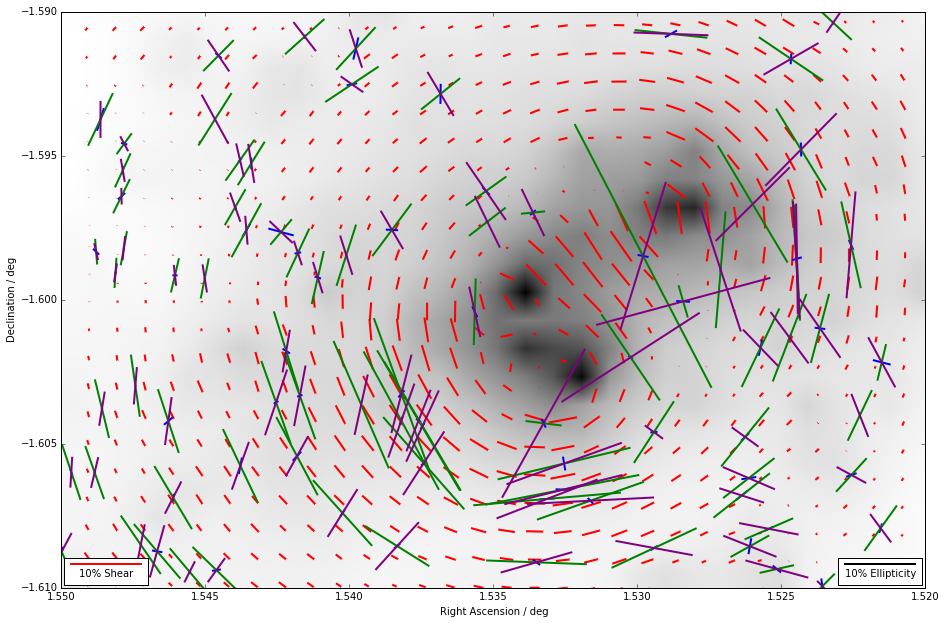

In [12]:
K.plot(fig_size=15,subplot=[1.55,1.52,-1.61,-1.59])
S.plot()
#B.galaxies['ePhi_halo'] *= -1.0
B.plot(lensed='all',graph='stick')